# Lab: Experiment Tracking with Weights & Biases

## 90-Minute Group Activity

---

### Objective

In this lab, you will:
1. Set up Weights & Biases (W&B) as a team
2. Train neural networks with different configurations
3. Track and compare experiments in a shared dashboard
4. Analyze what works best

### Team Setup

- Work in teams of 3-4 students
- **One team member creates a W&B account** and shares the API key
- Everyone logs into the **same account** using the shared key
- Each team member runs **different experiments**
- All experiments appear in the **same dashboard** for easy comparison!

---

## Part 0: Setup (10 minutes)

### Team Setup Instructions

1. **ONE person in your team:** Create a W&B account at https://wandb.ai/site
2. **That person:** Go to https://wandb.ai/authorize and copy the API key
3. **Share the API key** with all team members (via chat, show screen, etc.)
4. **Everyone:** Use the shared key to login below

### Step 1: Install W&B

In [1]:
# Install wandb if not already installed
!pip install wandb -q

In [3]:
#install torch
!pip install torch torchvision torchaudio -q

### Step 2: Import Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

print(f"PyTorch: {torch.__version__}")
print(f"W&B: {wandb.__version__}")

PyTorch: 2.9.1
W&B: 0.23.1


### Step 3: Login to W&B with Shared API Key

**Important:** Everyone in the team uses the SAME API key!

Get the key from your team member who created the account.

In [ ]:
# Login to W&B using your team's shared API key
# Replace the string below with your team's actual API key!

TEAM_API_KEY = "<TEAM_API_KEY>"  # <-- Replace this!

wandb.login(key=TEAM_API_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/joshua/.netrc
wandb: Currently logged in as: wenningmann24135 (wenningmann24135-hochschule-ansbach-university-of-applie) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Step 4: Set Device

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cpu


---

## Part 1: Load Data (5 minutes)

In [7]:
# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST (more challenging than MNIST)
train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

print(f"Training: {len(train_data)} images")
print(f"Test: {len(test_data)} images")
print(f"Classes: {train_data.classes}")

100.0%
100.0%
100.0%
100.0%

Training: 60000 images
Test: 10000 images
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


---

## Part 2: Define Models (Already Done for You)

In [8]:
# ============================================================
# MODEL DEFINITIONS - DO NOT MODIFY
# ============================================================

class SimpleMLP(nn.Module):
    """Simple MLP without any regularization."""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.layers(x)


class MLPWithDropout(nn.Module):
    """MLP with Dropout regularization."""
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.layers(x)


class MLPWithBatchNorm(nn.Module):
    """MLP with Batch Normalization."""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.layers(x)


class MLPFull(nn.Module):
    """MLP with BatchNorm and Dropout."""
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.layers(x)


class SimpleCNN(nn.Module):
    """Simple CNN for comparison."""
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


print("Models defined:")
print("  - SimpleMLP")
print("  - MLPWithDropout")
print("  - MLPWithBatchNorm")
print("  - MLPFull (BatchNorm + Dropout)")
print("  - SimpleCNN")

Models defined:
  - SimpleMLP
  - MLPWithDropout
  - MLPWithBatchNorm
  - MLPFull (BatchNorm + Dropout)
  - SimpleCNN


---

## Part 3: Training Function with W&B Tracking

In [9]:
def train_with_wandb(config):
    """
    Train a model and log everything to W&B.
    
    Args:
        config: dict with training configuration
    """
    
    # Initialize W&B run
    run = wandb.init(
        project="week9-neural-networks",
        config=config,
        name=config.get('run_name', None)
    )
    
    # Get config (W&B might modify it)
    config = wandb.config
    
    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False)
    
    # Create model
    if config.model_type == "SimpleMLP":
        model = SimpleMLP()
    elif config.model_type == "MLPWithDropout":
        model = MLPWithDropout(config.dropout_rate)
    elif config.model_type == "MLPWithBatchNorm":
        model = MLPWithBatchNorm()
    elif config.model_type == "MLPFull":
        model = MLPFull(config.dropout_rate)
    elif config.model_type == "SimpleCNN":
        model = SimpleCNN()
    else:
        raise ValueError(f"Unknown model: {config.model_type}")
    
    model = model.to(device)
    
    # Log model architecture
    wandb.watch(model, log='all', log_freq=100)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Training loop
    for epoch in range(config.epochs):
        
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(test_loader)
        val_acc = 100 * val_correct / val_total
        
        # Log to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss_avg,
            "train_accuracy": train_acc,
            "val_loss": val_loss_avg,
            "val_accuracy": val_acc,
            "train_val_gap": train_acc - val_acc
        })
        
        print(f"Epoch {epoch+1}/{config.epochs} | "
              f"Train: {train_acc:.1f}% | Val: {val_acc:.1f}%")
    
    # Log final metrics
    wandb.summary["final_train_acc"] = train_acc
    wandb.summary["final_val_acc"] = val_acc
    wandb.summary["final_gap"] = train_acc - val_acc
    
    # Finish run
    wandb.finish()
    
    return val_acc

print("Training function ready!")

Training function ready!


---

## Part 4: Run Your Experiments! (60 minutes)

### Instructions

1. **Each team member** picks different experiments from the list below
2. **Add your name** to the run_name so you can identify your experiments
3. **Run the cell** to train and log to W&B
4. **Check the W&B dashboard** - all team experiments appear together!

### How to Divide Work (Example for 4 people)

| Person | Experiments |
|--------|-------------|
| Joshi| Baseline (A) + Learning Rate 0.01 (B) |
| Mike | Learning Rate 0.0001 (B) + Batch Size 32 (C) |
| Anouk | Batch Size 256 (C) + Dropout 0.5 (D) |
| Zusammen| Architecture: BatchNorm (E) + CNN (E) |

### Experiments to Run

---

### Experiment A: Baseline (Everyone runs this first!)

In [10]:
# ============================================================
# EXPERIMENT A: BASELINE
# Run this first to establish a baseline!
# ============================================================

# YOUR NAME HERE (so we can identify your runs in the dashboard)
MY_NAME = "Joshi"  # <-- Change this to your name!

config_baseline = {
    "run_name": f"baseline-{MY_NAME}",  # Your name is added automatically
    "model_type": "SimpleMLP",
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 10,
    "dropout_rate": 0.0
}

train_with_wandb(config_baseline)

Epoch 1/10 | Train: 81.9% | Val: 84.0%
Epoch 2/10 | Train: 86.5% | Val: 86.1%
Epoch 3/10 | Train: 87.9% | Val: 86.0%
Epoch 4/10 | Train: 88.6% | Val: 87.2%
Epoch 5/10 | Train: 89.4% | Val: 87.0%
Epoch 6/10 | Train: 89.9% | Val: 87.2%
Epoch 7/10 | Train: 90.4% | Val: 88.3%
Epoch 8/10 | Train: 90.8% | Val: 86.8%
Epoch 9/10 | Train: 91.2% | Val: 88.5%
Epoch 10/10 | Train: 91.7% | Val: 88.7%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
train_val_gap,▁▄▅▅▆▆▆█▇▇
val_accuracy,▁▄▄▆▆▆▇▅██
val_loss,█▄▄▂▂▃▁▄▁▁
epoch,10
final_gap,3.03833
final_train_acc,91.71833
final_val_acc,88.68
train_accuracy,91.71833


88.68

---

### Experiment B: Learning Rate Comparison

**Divide among team:** Each person tries a different learning rate!

| Person | Learning Rate |
|--------|---------------|
| Joshi | 0.01 |
| Mike | 0.0001 |
| Anouk | 0.0005 |

In [15]:
# ============================================================
# EXPERIMENT B: LEARNING RATE
# Change the learning_rate value based on your assignment!
# ============================================================

config_lr = {
    "run_name": f"lr-0.0001-{MY_NAME}",  # <- Change the LR value in the name!
    "model_type": "SimpleMLP",
    "learning_rate": 0.0001,              # <- TRY: 0.01, 0.0001, or 0.0005
    "batch_size": 64,
    "epochs": 10,
    "dropout_rate": 0.0
}

train_with_wandb(config_lr)

Epoch 1/10 | Train: 77.1% | Val: 81.2%
Epoch 2/10 | Train: 84.2% | Val: 83.6%
Epoch 3/10 | Train: 85.5% | Val: 84.6%
Epoch 4/10 | Train: 86.3% | Val: 85.4%
Epoch 5/10 | Train: 87.0% | Val: 85.6%
Epoch 6/10 | Train: 87.6% | Val: 86.2%
Epoch 7/10 | Train: 88.1% | Val: 86.7%
Epoch 8/10 | Train: 88.5% | Val: 86.7%
Epoch 9/10 | Train: 88.8% | Val: 87.0%
Epoch 10/10 | Train: 89.0% | Val: 87.0%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
train_val_gap,▁▆▇▇▇▇▇███
val_accuracy,▁▄▅▆▆▇████
val_loss,█▅▄▃▃▂▁▁▁▁
epoch,10
final_gap,1.96667
final_train_acc,89.01667
final_val_acc,87.05
train_accuracy,89.01667


87.05

### Results Joshi (Red: Learning Rate = 0,01; Blue: LR = 0,001):
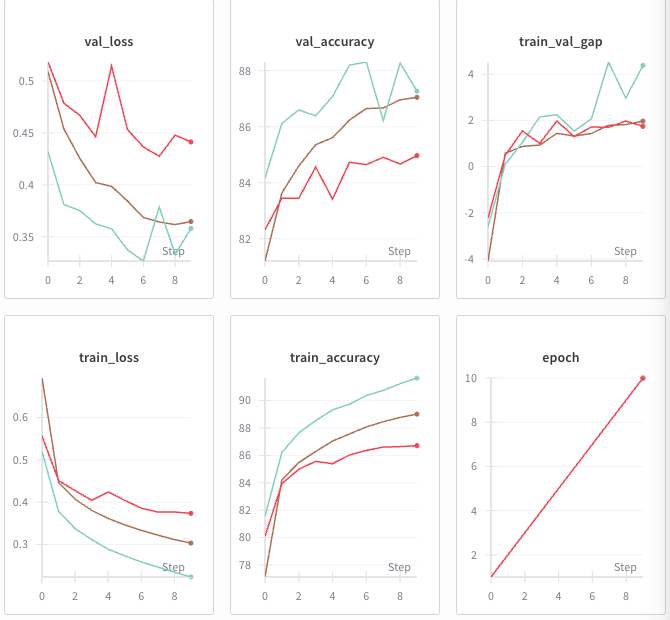
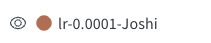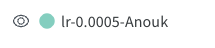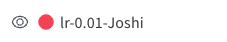

--> Baselinemodel (Blue) performed better over all metrics -> LR of 0,001 is better than 0,01

## Die Learning Rate steuert die Stabilität und Effizienz der Optimierung – zu groß → instabil, zu klein → langsam.

---

### Experiment C: Batch Size Comparison

**Divide among team:** Each person tries a different batch size!

| Person | Batch Size |
|--------|------------|
| Person 1 | 32 |
| Person 2 | 128 |
| Person 3 | 256 |

In [19]:
# ============================================================
# EXPERIMENT C: BATCH SIZE
# Change the batch_size value based on your assignment!
# ============================================================

config_batch = {
    "run_name": f"batch-32-{MY_NAME}",  # <- Change the batch value in the name!
    "model_type": "SimpleMLP",
    "learning_rate": 0.001,
    "batch_size": 32,                    # <- TRY: 32, 128, or 256
    "epochs": 10,
    "dropout_rate": 0.0
}

train_with_wandb(config_batch)

Epoch 1/10 | Train: 82.2% | Val: 85.0%
Epoch 2/10 | Train: 86.4% | Val: 86.6%
Epoch 3/10 | Train: 87.7% | Val: 86.8%
Epoch 4/10 | Train: 88.7% | Val: 87.3%
Epoch 5/10 | Train: 89.2% | Val: 87.5%
Epoch 6/10 | Train: 89.9% | Val: 87.6%
Epoch 7/10 | Train: 90.3% | Val: 87.0%
Epoch 8/10 | Train: 90.8% | Val: 87.7%
Epoch 9/10 | Train: 91.1% | Val: 88.2%
Epoch 10/10 | Train: 91.6% | Val: 88.3%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
train_val_gap,▁▄▅▆▆▇██▇█
val_accuracy,▁▄▅▆▆▆▅▇██
val_loss,█▄▄▃▂▁▅▃▃▁
epoch,10
final_gap,3.26167
final_train_acc,91.56167
final_val_acc,88.3
train_accuracy,91.56167


88.3

### Results Batch Size

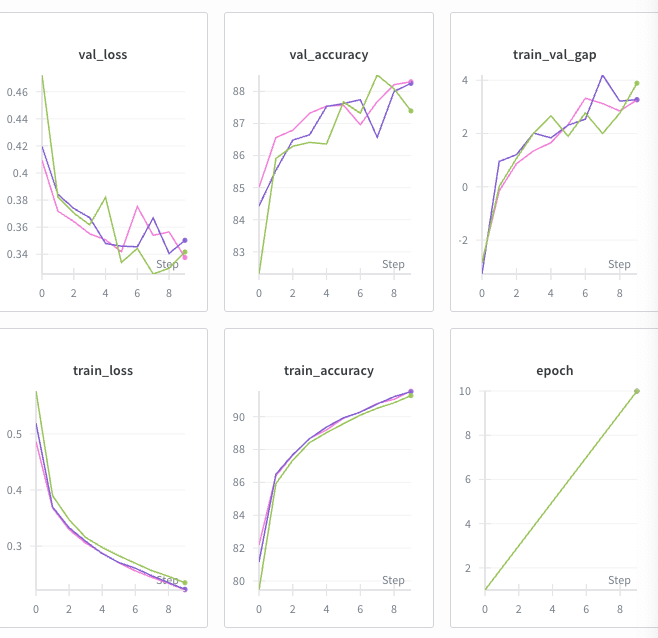
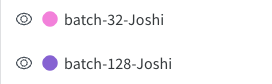
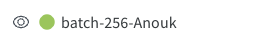

---

### Experiment D: Dropout Rate

**Divide among team:** Each person tries a different dropout rate!

| Person | Dropout Rate |
|--------|--------------|
| Person 1 | 0.2 |
| Person 2 | 0.5 |
| Person 3 | 0.7 |

In [17]:
# ============================================================
# EXPERIMENT D: DROPOUT RATE
# Change the dropout_rate value based on your assignment!
# ============================================================

config_dropout = {
    "run_name": f"dropout-0.2-{MY_NAME}",  # <- Change the dropout value in the name!
    "model_type": "MLPWithDropout",
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 10,
    "dropout_rate": 0.2                     # <- TRY: 0.2, 0.5, or 0.7
}

train_with_wandb(config_dropout)

Epoch 1/10 | Train: 80.5% | Val: 84.5%
Epoch 2/10 | Train: 85.3% | Val: 85.6%
Epoch 3/10 | Train: 86.2% | Val: 86.3%
Epoch 4/10 | Train: 87.2% | Val: 87.0%
Epoch 5/10 | Train: 87.7% | Val: 87.4%
Epoch 6/10 | Train: 88.1% | Val: 87.2%
Epoch 7/10 | Train: 88.3% | Val: 87.7%
Epoch 8/10 | Train: 88.6% | Val: 87.4%
Epoch 9/10 | Train: 89.0% | Val: 87.9%
Epoch 10/10 | Train: 89.4% | Val: 88.0%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇▇▇▇██
train_loss,█▄▄▃▂▂▂▁▁▁
train_val_gap,▁▆▆▆▇▇▇███
val_accuracy,▁▃▅▆▇▇▇▇██
val_loss,█▆▅▃▃▄▂▂▂▁
epoch,10
final_gap,1.43167
final_train_acc,89.42167
final_val_acc,87.99
train_accuracy,89.42167


87.99

## Results Drop out Rate
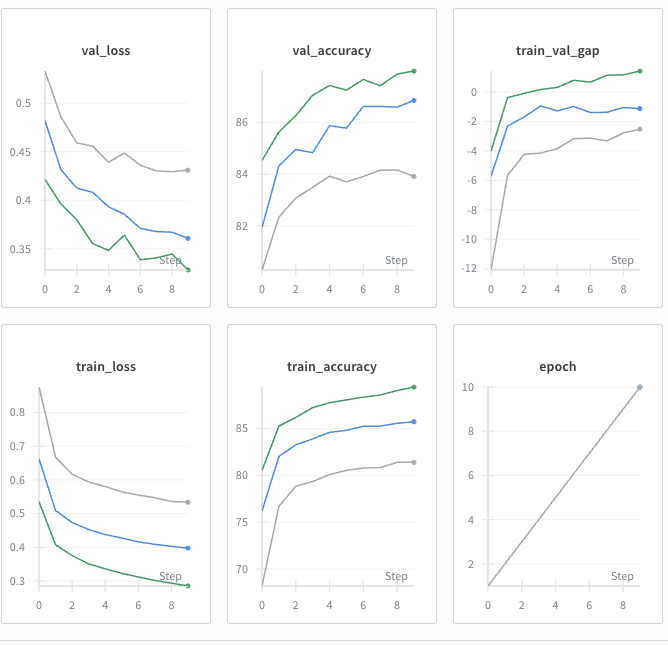
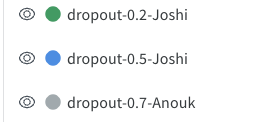

---

### Experiment E: Model Architecture

**Divide among team:** Each person tries a different architecture!

| Person | Model |
|--------|-------|
| All | MLPWithBatchNorm |
| Person 2 | MLPFull |
| Person 3 | SimpleCNN |

In [23]:
# ============================================================
# EXPERIMENT E: MODEL ARCHITECTURE
# Change the model_type value based on your assignment!
# ============================================================

config_model = {
    "run_name": f"Best_Config_Merged_DO==.5-{MY_NAME}",  # <- Change the model name!
    "model_type": "SimpleCNN",          # <- TRY: "MLPWithBatchNorm", "MLPFull", or "SimpleCNN"
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 10,
    "dropout_rate": 0.3
}

train_with_wandb(config_model)

Epoch 1/10 | Train: 84.1% | Val: 87.8%
Epoch 2/10 | Train: 89.8% | Val: 89.7%
Epoch 3/10 | Train: 91.5% | Val: 90.3%
Epoch 4/10 | Train: 92.6% | Val: 91.3%
Epoch 5/10 | Train: 93.5% | Val: 91.4%
Epoch 6/10 | Train: 94.4% | Val: 91.4%
Epoch 7/10 | Train: 95.1% | Val: 91.6%
Epoch 8/10 | Train: 95.8% | Val: 91.3%
Epoch 9/10 | Train: 96.3% | Val: 91.6%
Epoch 10/10 | Train: 97.0% | Val: 91.8%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
train_val_gap,▁▄▅▅▆▆▇▇██
val_accuracy,▁▄▅▇▇▇█▇██
val_loss,█▄▃▁▁▁▂▆▃▅
epoch,10
final_gap,5.225
final_train_acc,97.005
final_val_acc,91.78
train_accuracy,97.005


91.78

## Results Model comparison (Batch Size = 64; DO-Rate = 0,3; LR = 0.001)
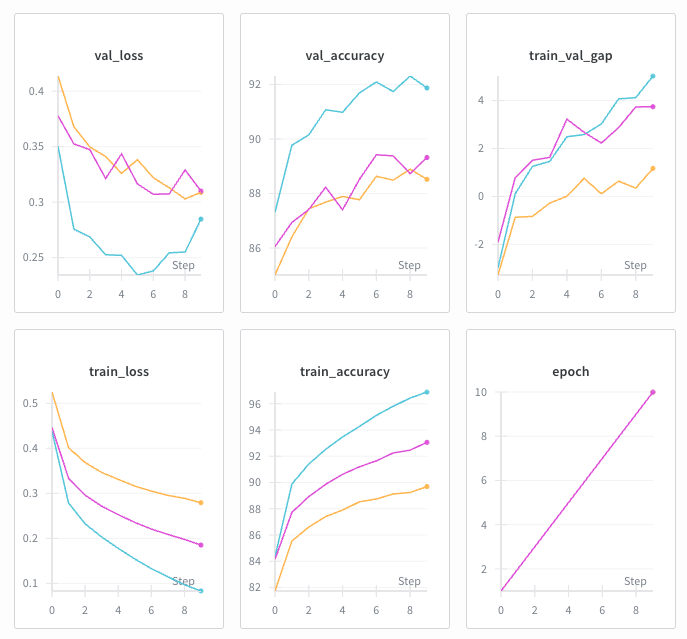
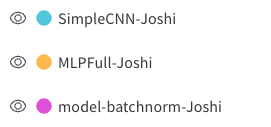

---

## Part 5: Analysis (15 minutes)

### Go to your Team's W&B Dashboard

1. Open: https://wandb.ai/
2. The account owner logs in (or use the dashboard link they share)
3. Find project: **week9-neural-networks**
4. Click on **Runs** to see ALL team experiments together!

### Compare Your Experiments

In the W&B dashboard:
1. Select multiple runs (click checkboxes)
2. View charts side-by-side
3. Compare metrics across all team experiments

### Answer These Questions Together

**Learning Rate:**
- Which learning rate gave the best validation accuracy?
- Which learning rate caused unstable training?
- What happened with very low learning rates?

**Batch Size:**
- How did batch size affect training speed?
- How did batch size affect final accuracy?

**Dropout:**
- How did dropout affect the train-val gap?
- Which dropout rate worked best?
- Was high dropout always better?

**Architecture:**
- Did BatchNorm help? How?
- Was CNN better than MLP?
- Which model generalized best (smallest train-val gap)?

### Record Your Team Findings

In [ ]:
# ============================================================
# RECORD YOUR TEAM FINDINGS HERE
# ============================================================

team_findings = """
TEAM FINDINGS:

Team Members: Joshua, Mike, Anouk

Best Learning Rate: 0,0005
Why: A learning rate of 0.0005 is large enough to make meaningful parameter updates and reach a good minimum within the given number of epochs, 
while 0.0001 updates the weights too slowly and underfits. In short, 0.0005 hits the speed–stability sweet spot, whereas 0.0001 wastes training time.

Best Batch Size: ? --> really close together
Why:Because in your setup all tested batch sizes fall into a “stable regime” where optimization dynamics don’t change much.
More specifically:
	•	The batches are large enough to give reliable gradient estimates, so changing them doesn’t alter the update direction significantly.
	•	learning rate and model capacity dominate the behavior, masking batch-size effects.
	•	Batch size mainly affects training speed and noise, not the final solution, once it’s above a certain threshold.

Best Dropout Rate: 0,2
Why: Because dropout = 0.2 provides enough regularization to reduce overfitting without suppressing learning.
Higher dropout rates (0.5, 0.7) remove too much signal and cause underfitting, 
while lower dropout does not regularize enough—making 0.2 the best bias–variance tradeoff for your model and dataset.

Best Model: CNN
Why: Best performance overall.


Overall Best Configuration:
- Model: CNN
- Learning Rate: 0.001
- Batch Size: 64
- Dropout: 0.3
- Final Accuracy: Val: 91.8%

Surprising Observations:
- Batch size doesnt have much influence on perormance
- the lowest learning rate performed worst
- Dropout of 0.2 was best, higher values led to underfitting

Key Learnings:


"""

print(team_findings)


TEAM FINDINGS:

Team Members: Joshua, Mike, Anouk

Best Learning Rate: 0,0005
Why: A learning rate of 0.0005 is large enough to make meaningful parameter updates and reach a good minimum within the given number of epochs, 
while 0.0001 updates the weights too slowly and underfits. In short, 0.0005 hits the speed–stability sweet spot, whereas 0.0001 wastes training time.

Best Batch Size: ? --> really close together
Why:Because in your setup all tested batch sizes fall into a “stable regime” where optimization dynamics don’t change much.
More specifically:
	•	The batches are large enough to give reliable gradient estimates, so changing them doesn’t alter the update direction significantly.
	•	Your learning rate and model capacity dominate the behavior, masking batch-size effects.
	•	Batch size mainly affects training speed and noise, not the final solution, once it’s above a certain threshold.

Best Dropout Rate: 0,2
Why: Because dropout = 0.2 provides enough regularization to reduce o

---

## Bonus: Run Your Own Experiment

Try your own configuration!

In [ ]:
# ============================================================
# YOUR CUSTOM EXPERIMENT
# Try your team's best configuration or something new!
# ============================================================

config_custom = {
    "run_name": f"custom-{MY_NAME}",
    "model_type": "MLPFull",           # Choose your model
    "learning_rate": 0.001,            # Choose your LR
    "batch_size": 64,                  # Choose your batch size
    "epochs": 15,                      # Try more epochs?
    "dropout_rate": 0.3                # Choose dropout
}

# Uncomment to run:
# train_with_wandb(config_custom)

---

## Summary

### What You Learned

1. **W&B makes experiment tracking easy**
   - Automatic logging of metrics
   - Beautiful visualizations
   - Easy comparison across runs

2. **Hyperparameters matter!**
   - Learning rate: Most important hyperparameter
   - Batch size: Affects stability and speed
   - Dropout: Reduces overfitting

3. **Architecture choices affect results**
   - BatchNorm: Faster, more stable training
   - CNN: Better for images
   - Regularization: Helps generalization

### Key W&B Commands

```python
wandb.init(project="name", config={...})  # Start tracking
wandb.log({"metric": value})              # Log during training
wandb.finish()                             # End run
```

---

**Great job! You're now ready to track your own ML experiments professionally!**